In [1]:
from pymongo import MongoClient
import gensim
from gensim import corpora, models, similarities, matutils
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from nltk.stem import WordNetLemmatizer
import random

In [2]:
###  Set up texts dictionary  ###
###  Keys - Name of Collection  ###
###  Values - List of Texts (NYT Articles)  ###
wordnet_lemmatizer = WordNetLemmatizer()
texts = {}
text_lemmas = {}

db = MongoClient('localhost', 27017)['politician_db']
collection_names = db.list_collection_names()

chunks = [[],[],[],[],[],[]]
for i, name in enumerate(collection_names):
    for j in range(6):
        if i%6 == j:
            chunks[j].append(name)

for chunk in chunks:
    time.sleep(1)
    for name in tqdm(chunk):
        time.sleep(0.2)
        texts[name] = []
        text_lemmas[name] = []
        for doc in db[name].find():
            lemmalist = []
            try:
                texts[name].append(doc['full_text'])
                for word in doc['full_text'].split():
                    lemmalist.append(wordnet_lemmatizer.lemmatize(word))
                text_lemmas[name].append(" ".join(lemmalist))
            except:
                pass

100%|██████████| 56/56 [00:44<00:00,  2.48it/s]


In [3]:
#len(list(texts.keys()))

In [4]:
#texts['tomprice']

In [5]:
###  Finding Politicians of Interest with Specified Keywords  ###

words_of_interest = ['scandal','resign', 'fired', 'sex', 'drugs', 'corruption', 'mistress']
ppl_of_interest = []
for name in collection_names:
    done = False
    for text in text_lemmas[name]:
        for word in words_of_interest:
            if word in text:
                ppl_of_interest.append(name)
                print(f'{name} is a person of interest', end=' - ')
                print(word)
                done = True
                break
        if done:
            break

jedgarhoover is a person of interest - scandal
donaldregan is a person of interest - scandal
williamhseward is a person of interest - sex
garyflocke is a person of interest - sex
jacobjlew is a person of interest - sex
anndoremclaughlin is a person of interest - resign
samuelkskinner is a person of interest - resign
georgewbush is a person of interest - resign
elainechao is a person of interest - scandal
elizabethhdole is a person of interest - resign
jamesspeed is a person of interest - resign
anthonylake is a person of interest - scandal
howardbaker is a person of interest - scandal
williamfrenchsmith is a person of interest - resign
malcolmbaldrige is a person of interest - drugs
mikepompeo is a person of interest - scandal
sylviamathewsburwell is a person of interest - sex
lutherhhodges is a person of interest - resign
billclinton is a person of interest - sex
williamssessions is a person of interest - resign
michaeloleavitt is a person of interest - drugs
carlosmgutierrez is a per

In [6]:
len(ppl_of_interest)

144

In [7]:
###  Finding the frequency of keywords in corpora of politicians  ###

counts = []

for name in ppl_of_interest:
    scandalcount = 0
    for item in text_lemmas[name]:
        for token in item.split():
            if token in words_of_interest:
                scandalcount += 1
    counts.append((scandalcount,name))

counts.sort(key=lambda x: x[0],reverse=True)

counts

[(1027, 'janetreno'),
 (589, 'mikepence'),
 (513, 'albertogonzales'),
 (461, 'dickcheney'),
 (356, 'danquayle'),
 (338, 'billclinton'),
 (306, 'johnashcroft'),
 (288, 'condoleezzarice'),
 (273, 'williamfrenchsmith'),
 (263, 'johnkerry'),
 (255, 'ronaldreagan'),
 (254, 'edwinmeese'),
 (250, 'jedgarhoover'),
 (247, 'abrahamlincoln'),
 (233, 'rextillerson'),
 (227, 'hrmcmaster'),
 (220, 'cdouglasdillon'),
 (201, 'warrenchristopher'),
 (196, 'williamscohen'),
 (172, 'williamhwebster'),
 (171, 'roberterubin'),
 (167, 'georgewbush'),
 (162, 'dickthornburgh'),
 (157, 'colinpowell'),
 (149, 'raymondjdonovan'),
 (140, 'ericholder'),
 (138, 'kathleensebelius'),
 (129, 'williamjperry'),
 (129, 'scottpruitt'),
 (119, 'donaldtrump'),
 (114, 'january'),
 (113, 'lloydbentsen'),
 (102, 'madeleinealbright'),
 (101, 'jamescomey'),
 (98, 'bencarson'),
 (97, 'louisfreeh'),
 (96, 'christopherawray'),
 (88, 'donnashalala'),
 (87, 'anthonylake'),
 (84, 'lorettalynch'),
 (84, 'jackfkemp'),
 (81, 'jacobjlew'),

In [14]:
###  Functions used to plot, clean data ###

def pub_date_to_datetime(s):
    s = s[:10]
    l = s.split('-')
    d = datetime.date(year=int(l[0]),month=int(l[1]),day=int(l[2]))
    return d

def plot_keywords(name):
    dates = []
    counts = []
    words_of_interest = ['scandal','resign']
    for item in db[name].find():
        scandalcount = 0
        try:
            for word in item['full_text'].split():
                if word in words_of_interest:
                    scandalcount += 1
            counts.append(scandalcount)
            dates.append(pub_date_to_datetime(item['pub_date']).year + pub_date_to_datetime(item['pub_date']).month/12)
        except:
            pass
    df = pd.DataFrame({'dates':dates,'counts':counts})
    df = df.groupby(by='dates',as_index=False).sum()
    x = df.dates
    y = df.counts
    sns.scatterplot(x=x,y=y)
    plt.title('Keyword Frequency')
    plt.show()
    
def plot_sentiment(name):
    tuplist = []
    analyzer = SentimentIntensityAnalyzer()
    for item in db[name].find():
        try:
            sent = analyzer.polarity_scores(item['full_text'])['compound']
            tuplist.append((pub_date_to_datetime(item['pub_date']),sent))
        except:
            pass
    tuplist.sort(key=lambda x:x[0])
    divisor = len(tuplist)//30
    if divisor < 4:
        divisor = 4
    dates = []
    aves = []
    running_tot = 0
    count = 0
    for i,item in enumerate(tuplist):
        running_tot += item[1]
        count += 1
        if i >= divisor-1:
            running_tot -= tuplist[i-(divisor-1)][1]
            aves.append(running_tot/divisor)
        else:
            aves.append(running_tot/count)
        dates.append(item[0])
    sns.lineplot(x=dates,y=aves, err_style=None)
    plt.title('Sentiment Over Time')
    plt.show()
    
def plot_frequency(name):
    months = []
    for item in db[name].find():
        months.append(pub_date_to_datetime(item['pub_date']).year + pub_date_to_datetime(item['pub_date']).month/12)
    sns.distplot(months, bins=len(set(months)))
    plt.title('Frequency of Article Mentions')
    plt.show()
    


In [19]:
###  Following Cells plot the name stored showing thier:  ###
###  Frequency of Keywords
###  Frequency of Articles published
###  Rolling Average Sentiment

plot_name = 'scottpruitt'

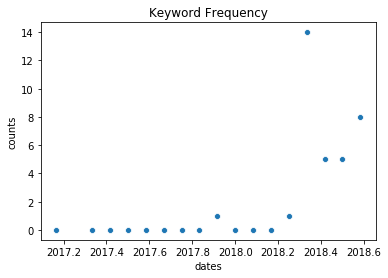

In [20]:
plot_keywords(plot_name)

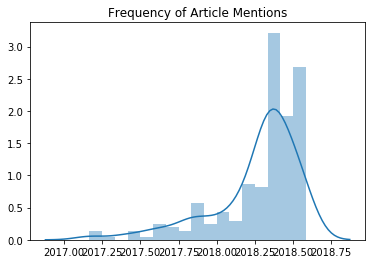

In [21]:
plot_frequency(plot_name)

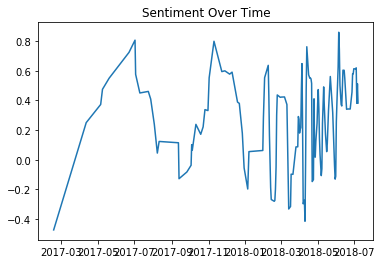

In [22]:
plot_sentiment(plot_name)

In [13]:
df = pd.read_pickle('pol_df.pkl')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'pol_df.pkl'

In [ ]:
### Fixing Party Affiliation  ###

pres_df = df[df.Role == 'President']
pres_df = pres_df[['Party','President']]
#pres_df
map_dict = {}
for entry in pres_df.values:
    map_dict[entry[1]] = entry[0]
#map_dict

In [ ]:
parties = []
for entry in df.values:
    if entry[4] in map_dict.keys():
        entry[3] = map_dict[entry[4]]
        parties.append(entry[3])
    else:
        parties.append('Not Available')
df['Party'] = parties

In [ ]:
#df

In [ ]:
labels = open('Labels.txt', 'r')
labs = [s[-2] for s in labels]
#labs

In [ ]:
labels = open('Labels.txt', 'r')
names = []
for line in labels:
    names.append(line.split("'")[1])

In [ ]:
#names

In [ ]:
print(len(names), len(labs))

In [ ]:
#df_sub = df[df.collectionname in ppl_of_interest]
#df_sub
mapper = pd.DataFrame({'collectionname':names,'label':labs})
mapper.label = mapper.label.apply(lambda x: '0' if x != '1' else x)
#mapper

In [ ]:
rest = set(df.collectionname) - set(mapper.collectionname)

first_set = [value for value in mapper.collectionname]
first_labs = labs

sec_set = [name for name in rest]
sec_labs = [0 for _ in range(len(rest))]

for i in range(len(sec_set)):
    first_set.append(sec_set[i])
    first_labs.append(sec_labs[i])
    
mapper = pd.DataFrame({'collectionname':first_set,'label':first_labs})
#mapper

In [ ]:
df = pd.merge(df,mapper,on='collectionname')
df.label = df.label.apply(lambda x: '0' if x==',' else x)
df.label = df.label.apply(lambda x: '0' if x=="'" else x)
df.label = df.label.apply(lambda x: '0' if x==" " else x)
df.label = df.label.apply(lambda x: int(x))
df = df[df.label < 2]
#df

In [ ]:
df.groupby(by='label').count()

In [ ]:
pos = df[df.label == 1]
count = 0
for name in pos.collectionname:
    try:
        count += len(texts[name])
    except:
        pass
count

In [ ]:
neg = df[df.label == 0]
count = 0
for name in neg.collectionname:
    try:
        count += len(texts[name])
    except:
        pass
count

## Train - Test Splitting the Data

I will select 4 positive class politicians (by hand) and 73 negative class politicians (randomly) to create a holdout set.  Though the act of selcting the test set will impose my own bias on the models, it will overcome the (debatably) bigger problem of testing on irrelevant politicians. To maximize the relevance/randomness balance, I will randomly choose 2 politicians from the Trump administration, 1 from the Obama admin., and 1 from the George W. Bush admin.

**Note - Do not run these cells more than once, commented out for safety**

In [ ]:
# bush_df = df[df.President == 'George W. Bush']
# bush_df = bush_df[bush_df.label == 1]
# #bush_df

# rn = random.randint(0,4)
# bush_test_row = bush_df.values[rn]

# bush_test_row

# obama_df = df[df.President == 'Barack Obama']
# obama_df = obama_df[obama_df.label == 1]
# obama_df

# rn = random.randint(0,1)
# obama_test_row = obama_df.values[rn]

# obama_test_row

# trump_df = df[df.President == 'Donald Trump']
# trump_df = trump_df[trump_df.label == 1]
# trump_df

# rn1 = random.randint(0,2)
# rn2 = random.randint(0,2)
# trump_test_row1 = trump_df.values[rn1]
# trump_test_row2 = trump_df.values[rn2]

# trump_test_row1

# trump_test_row2

# df_test = pd.DataFrame([bush_test_row,obama_test_row,trump_test_row1,trump_test_row2])
# df_test.columns = df.columns
# df_test

In [ ]:
# xtestpos = pd.read_pickle('pos_test_df')
# xtestpos['Party'] = ['Republican', 'Democratic','Republican','Republican']
# xtestpos

In [ ]:
# pd.to_pickle(xtestpos,'pos_test_df')

## Generating the negative class test set

Generating 75 random integer indices and grabbing them from the negative class dataframe

In [ ]:
# neg

In [ ]:
# neg_test = neg.reset_index()
# neg_test = neg_test.drop('index',axis=1)
# neg_test

In [ ]:
# rns = [random.randint(0,447) for _ in range(80)]
# print(len(rns),len(set(rns)))

In [ ]:
# rns.sort()
# rns

In [ ]:
# neg_test = neg_test.iloc[list(set(rns))]
# neg_test = neg_test.reset_index()
# neg_test = neg_test.drop('index',axis=1)
# neg_test

In [ ]:
# pd.to_pickle(neg_test, 'neg_test_df.pkl')

In [ ]:
# test_df = pd.concat([xtestpos,neg_test])

# test_df = test_df.reset_index()
# test_df = test_df.drop('index',axis=1)
# test_df

In [ ]:
# pd.to_pickle(test_df,'test_df.pkl')

In [ ]:
# train_df = df
# for name in test_df.collectionname:
#     train_df = train_df[train_df.collectionname != name]

In [ ]:
# pd.to_pickle(train_df,'train_df.pkl')